In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import time
import glob
import tqdm
import torch
import warnings
import numpy as np
import chnet.cahn_hill as ch
import chnet.ch_tools as tools
import matplotlib.pyplot as plt
from toolz.curried import pipe, curry, compose, memoize

In [2]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [3]:
def get_free_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    return np.argmax(memory_available)

In [4]:
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=5)

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
    
def rmserror(x, y):
    return np.sqrt(np.mean((x - y)**2))

# def init_unif(nsamples, dim_x, dim_y, seed=354875, scale=0.1):
#     np.random.seed(seed)
#     return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))*scale


# def init_norm(nsamples, dim_x, dim_y, seed=354875):
#     np.random.seed(seed)
#     means  = np.random.uniform(-0.1, 0.1, size=nsamples)
#     scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
#     x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
#     x_data = np.concatenate(x_data, axis=0)
    
#     np.clip(x_data, -0.95, 0.95, out=x_data)
    
#     return x_data

def init_unif(nsamples, dim_x, dim_y,scale=0.1, seed=354875):
    np.random.seed(seed)
    return (2 * np.random.random((nsamples, dim_x, dim_y)) - 1) * scale


def init_norm(nsamples, dim_x, dim_y, scale_mean=0.1, scale_std=0.1, seed=354875):
    np.random.seed(seed)
    means  = (2 * np.random.random(nsamples) - 1) * scale_mean
    x_data = [np.random.normal(loc=m, scale=scale_std, size = (1, dim_x, dim_y)) for m in means]
    x_data = np.concatenate(x_data, axis=0)
    return x_data

def corr(x_data, y_data):
    return pipe(x_data, 
                lambda x: np.fft.fftn(x, axes=(0,1)), 
                lambda x: x * np.conj(np.fft.fftn(y_data, axes=(0,1))), 
                lambda x: np.fft.ifftn(x),
                lambda x: np.fft.fftshift(x), 
                lambda x: x.real) / x_data.size

In [5]:
nsamples = 100 # no. of samples
dim_x = 101
dim_y = dim_x
sim_steps = 100 # simulation steps
save_steps = 100 # time step for which data is saved
dx = 0.25 # delta space_dim
dt = 0.01 # delta time
gamma = 1.0 # interface energy
device = torch.device("cuda:0")

## Evolution and Free energy calculations for normal intial state microstructures

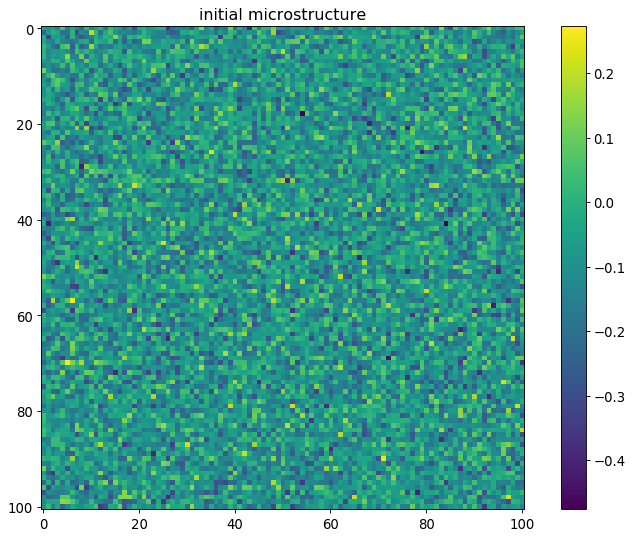

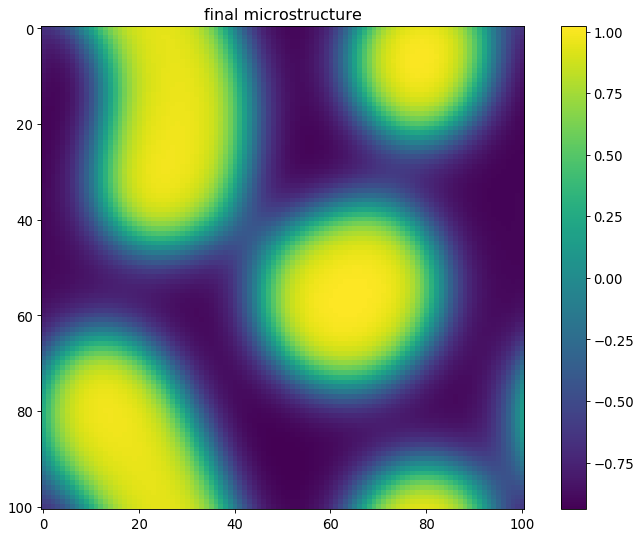

In [6]:
fe_norm = np.zeros((save_steps, nsamples))
x_data = init_norm(nsamples, dim_x, dim_y, seed=873452)
draw_im(x_data[0], "initial microstructure")

for i in tqdm.tqdm_notebook(range(save_steps)):
    x_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
    fe_norm[i,:] = tools.freeEnergy(x_data, delta_x=dx, gamma=gamma)
draw_im(x_data[0], "final microstructure")

## Evolution and Free energy calculations for uniform intial state microstructures

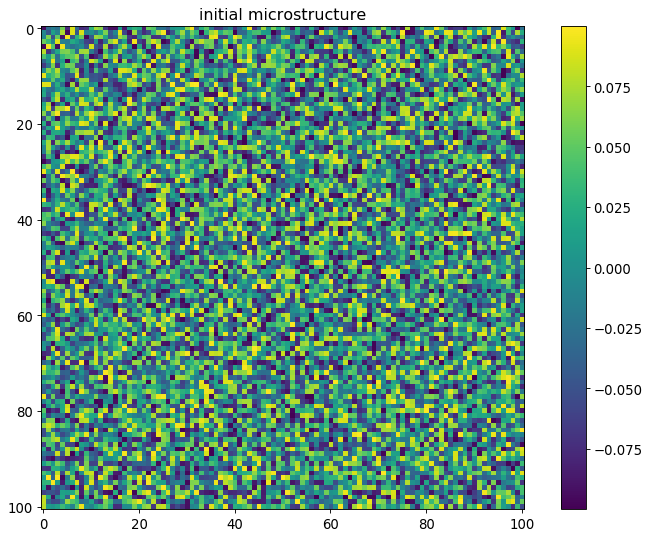

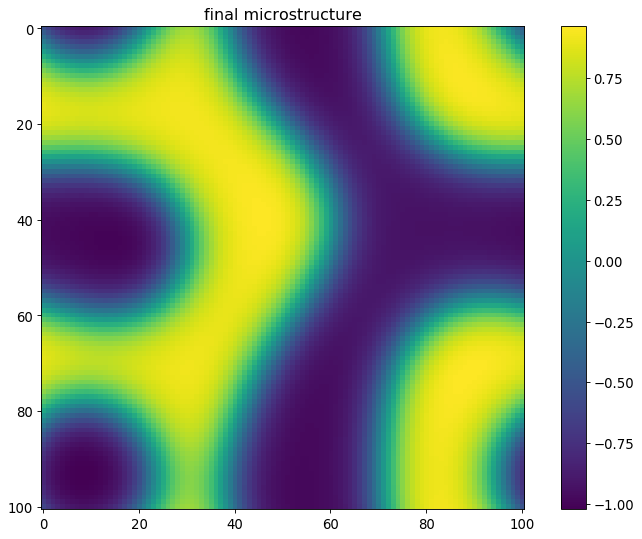

In [7]:
fe_unif = np.zeros((save_steps, nsamples))
x_data = init_unif(nsamples, dim_x, dim_y, seed=354875)
draw_im(x_data[0], "initial microstructure")
for i in tqdm.tqdm_notebook(range(save_steps)):
    x_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
    fe_unif[i,:] = tools.freeEnergy(x_data, delta_x=dx, gamma=gamma)
draw_im(x_data[0], "final microstructure") 

## Free Energy change with microstructure evolution

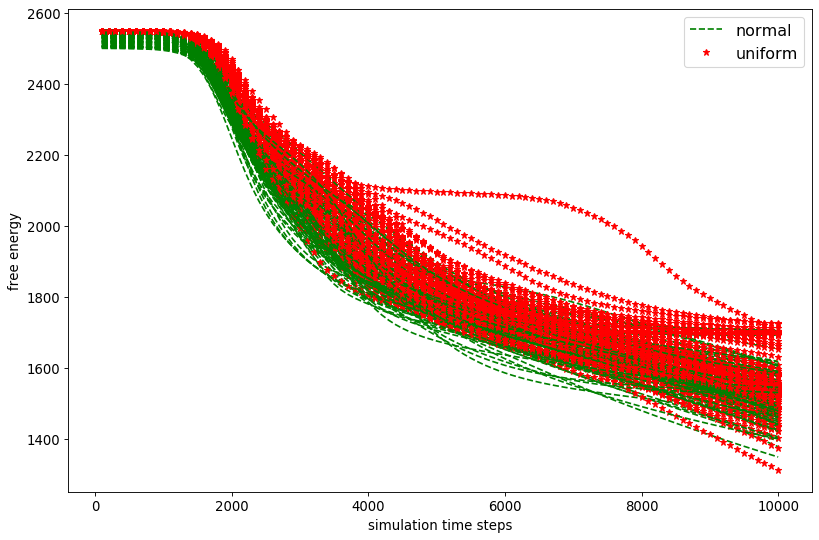

In [9]:
for i in range(nsamples):
    plt.plot(np.arange(1, save_steps+1) * sim_steps, fe_norm[:,i], "--g")
    plt.plot(np.arange(1, save_steps+1) * sim_steps, fe_unif[:,i], "*r")

plt.ylabel("free energy")
plt.xlabel("simulation time steps")
plt.legend(["normal", "uniform"])
plt.show()

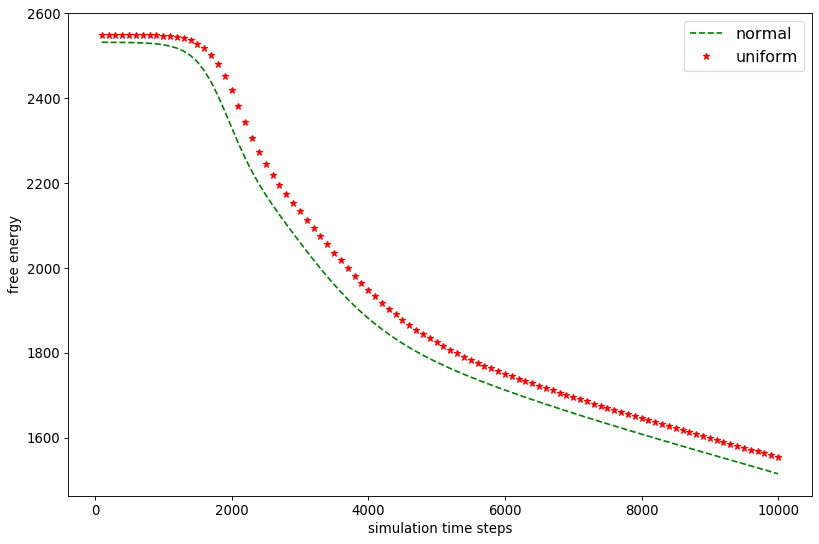

In [10]:
plt.plot(np.arange(1, save_steps+1) * sim_steps, np.mean(fe_norm, axis=1), "--g")
plt.plot(np.arange(1, save_steps+1) * sim_steps, np.mean(fe_unif, axis=1), "*r")
plt.ylabel("free energy")
plt.xlabel("simulation time steps")
plt.legend(["normal", "uniform"])
plt.show()

# Microstructure Evolution in PC space

In [11]:
import pymks
from pymks import LegendreBasis
from sklearn.decomposition import PCA

In [12]:
%%time
nsamples = 30 # no. of samples
dim_x = 101
dim_y = dim_x
sim_steps = 100 # simulation steps
save_steps = 100 # time step for which data is saved
dx = 0.25 # delta space_dim
dt = 0.01 # delta time
gamma = 1.0 # interface energy
device = torch.device("cuda:0")

CPU times: user 17 µs, sys: 2 µs, total: 19 µs
Wall time: 20.3 µs


In [13]:
%%time
domain = [-1.1, 1.1]
n_states = 5
basis = LegendreBasis(n_states, domain)

correlations=[(1,1), (1,2), (1,3), (1,4), 
              (2,2), (2,3), (2,4),
              (3,3), (3,4), 
              (4,4)]
stat_shape = (nsamples, (dim_x * dim_y * len(correlations)))


x_data1 = init_unif(nsamples//2, dim_x, dim_y, seed=354875)
x_data2 = init_unif(nsamples//2, dim_x, dim_y, seed=354875)

x_data = np.concatenate([x_data1, x_data2], axis=0)
y_data = x_data.copy()

f_data = []
fe_list = []
for i in tqdm.tqdm_notebook(range(save_steps)):
    y_data = ch.ch_run_torch(y_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
    fe_list.append(tools.freeEnergy(y_data, delta_x=dx, gamma=gamma))
    y_corr = pymks.stats.correlate(y_data, basis, periodic_axes=[0,1], correlations=correlations)
    f_data.append(np.reshape(y_corr, stat_shape))
f_data = np.concatenate(f_data, axis=0)
fe_list = np.concatenate(fe_list, axis=0)


CPU times: user 2min 19s, sys: 10 s, total: 2min 29s
Wall time: 37.6 s


In [14]:
%%time
pca = PCA(n_components=50)
scores = pca.fit_transform(f_data)

CPU times: user 20.6 s, sys: 1.09 s, total: 21.7 s
Wall time: 6.65 s


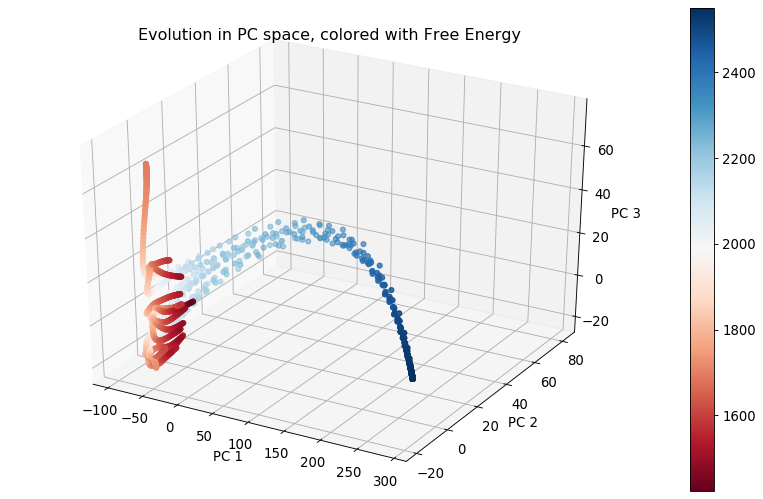

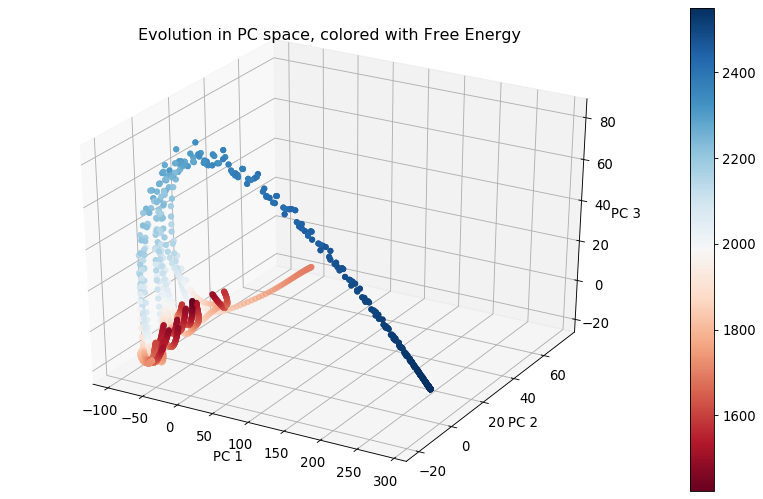

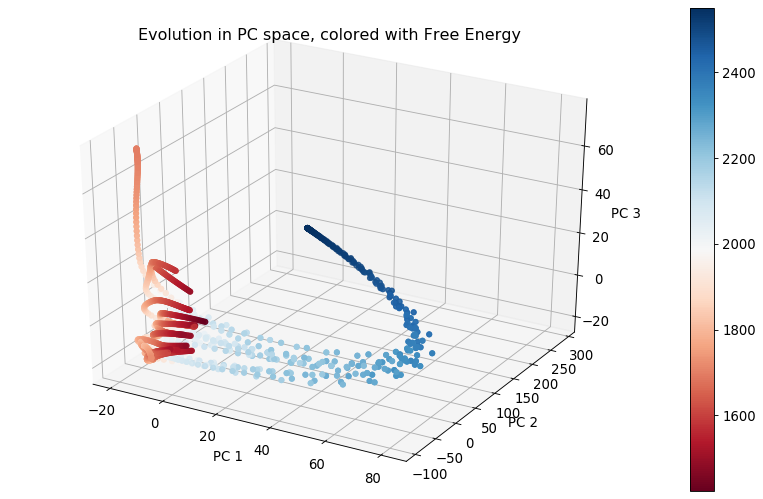

In [15]:
c = []
for i in range(save_steps):
    c = c + [i+1] * nsamples

sc = 8
fig = plt.figure(figsize=(sc*1.61803398, sc))
ax = fig.add_subplot(111, projection='3d')
c1 = ax.scatter(scores[:,0], scores[:,1], scores[:,2], c=fe_list, cmap='RdBu')
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("Evolution in PC space, colored with Free Energy")
cbar = plt.colorbar(c1)
plt.show()


sc = 8
fig = plt.figure(figsize=(sc*1.61803398, sc))
ax = fig.add_subplot(111, projection='3d')
c1 = ax.scatter(scores[:,0], scores[:,2], scores[:,1], c=fe_list, cmap='RdBu')
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("Evolution in PC space, colored with Free Energy")
cbar = plt.colorbar(c1)
plt.show()


sc = 8
fig = plt.figure(figsize=(sc*1.61803398, sc))
ax = fig.add_subplot(111, projection='3d')
c1 = ax.scatter(scores[:,1], scores[:,0], scores[:,2], c=fe_list, cmap='RdBu')
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("Evolution in PC space, colored with Free Energy")
cbar = plt.colorbar(c1)
plt.show()